In [1]:
import mysql.connector
import pandas as pd
import os
import pos_tag
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# 1. Создание базы данных

Моя база данных будет называться "inspector"

```
mydb = mysql.connector.connect(
  host="localhost",
  user="irene",
  password="Vasya123",
)
mycursor = mydb.cursor()
mycursor.execute("CREATE DATABASE inspector")
```

In [2]:
inspector = mysql.connector.connect(
    host="localhost",
    user="irene",
    password="Vasya123", 
    database="inspector"
)
ins_cursor = inspector.cursor()

In [3]:
ins_cursor.execute("SHOW DATABASES")

for x in ins_cursor:
    print(x)

('information_schema',)
('inspector',)
('mysql',)
('performance_schema',)
('schedule',)
('sys',)


# 2. Описание базы данных "inspector"

**Тема**: Автоматическое оценивание экзаменационных эссе на основании [синт., лекс., морф., дискурс.] факторов

**Задача**: база данных с текстами, разметкой [UdPipe](http://ufal.mff.cuni.cz/udpipe), ошибками на основании разметки корпуса [REALEC](http://realec.org), критериями, выделенными в ходе исследования

**Что нужно уметь вытаскивать**:

    1) По заданным start_pos и end_pos вывести ошибки на этом спане.

# 3. Нормальная форма базы данных "inspector"

**Таблицы** (если нет id в таблице, то ключ выделен "!"):

                            DICT_TOKENS

| id_token | token |
|:--------:|:-----:|
|INT       |TEXT   |

                            DICT_POS

| id_pos | pos |
|:------:|:---:|
|INT     |TEXT |

                            DICT_LEMMAS

| id_lemma | lemma |
|:--------:|:-----:|
|INT       |TEXT   |

                            DICT_RELATIONS

| id_relation | relation |
|:-----------:|:--------:|
|INT          |TEXT      |

                            DICT_TYPES_OF_MISTAKES

| id_type | type |
|:-------:|:----:|
|INT      |TEXT  |

                            DICT_CRITERIA

| id_criterion | criterion |
|:------------:|:---------:|
|INT           |TEXT       |

                            TEXTS

| id_text | name | text | mark |
|:-------:|:----:|:----:|:----:|
|INT      |TEXT  |TEXT  |TEXT  |

                            TOKENS

| id_token | !id_text | !start_pos | end_pos | id_pos | head | id_lemma | id_relation | grammar |
|:--------:|:--------:|:----------:|:-------:|:------:|:----:|:--------:|:-----------:|:-------:|
|INT       |INT       |INT         |INT      |INT     |INT   |INT       |INT          |TEXT     |

                            MISTAKES

| id_mistake | id_type | start_pos | end_pos | id_text |
|:----------:|:-------:|:---------:|:-------:|:-------:|
|INT         |INT      |INT        |INT      |INT      |

                            CRITERIA

| !id_text | !id_criterion | value |
|:--------:|:-------------:|:-----:|
|INT       |INT            |FLOAT  |

In [4]:
data = pd.read_csv('data.csv', index_col=0)#[0::10]

In [5]:
data.head()

,name,mark,path,text
0,AAl_13_1,best,./data/exam2014/AAl_13_1,The presented data shows us the percentage of ...
1,AAl_27_1,best,./data/exam2014/AAl_27_1,The graph provides data about the percentage o...
2,AAl_30_1,best,./data/exam2014/AAl_30_1,The diagram presents a number of people after ...
3,ZEv_3_1,best,./data/exam2014/ZEv_3_1,The charts provide information about travellin...
4,EEm_14_1,best,./data/exam2014/EEm_14_1,The given graph depicts the changes in the per...


In [6]:
len(data[data['mark']=='best'])

38

In [7]:
def annotation(path):
    with open(path + '.ann', 'r') as file:
        lines = file.readlines()
    i = 0
    for line in lines:
        if 'lemma' in line:
            break
        i += 1
    only_ann = [l.split('\t')[1].split() for l in lines[0:i-1] if l.startswith('T')]
    return only_ann

# 4. Создание таблиц

Пользователь вводит текст, оценку за эссе, так же загружает файл с аннотацией (в данном проекте и в моей дипломной работе берутся готовые из бд [REALEC](http://realec.org)). В дальнейшем будет осуществлен автоматический парсинг ошибок, тогда не нужно будет отдельно создавать аннотационный файл - это будет производиться автоматически.

Пример аннотационного файла:
```
T2	Spelling 459 468	situvoion
T7	Capitalisation 238 246	japanese
T8	Articles 531 538	Percent
```

In [8]:
ins_cursor.execute("DROP TABLE DICT_TOKENS, \
                                DICT_POS, \
                                DICT_LEMMAS, \
                                DICT_RELATIONS, \
                                DICT_TYPES_OF_MISTAKES, \
                                DICT_CRITERIA, \
                                TEXTS, \
                                TOKENS, \
                                MISTAKES, \
                                CRITERIA")

In [9]:
ins_cursor.execute("CREATE TABLE DICT_TOKENS (id_token INT AUTO_INCREMENT PRIMARY KEY, token TEXT);")
ins_cursor.execute("CREATE TABLE DICT_POS (id_pos INT AUTO_INCREMENT PRIMARY KEY, pos TEXT);")
ins_cursor.execute("CREATE TABLE DICT_LEMMAS (id_lemma INT AUTO_INCREMENT PRIMARY KEY, lemma TEXT);")
ins_cursor.execute("CREATE TABLE DICT_RELATIONS (id_relation INT AUTO_INCREMENT PRIMARY KEY, relation TEXT);")
ins_cursor.execute("CREATE TABLE DICT_TYPES_OF_MISTAKES (id_type INT AUTO_INCREMENT PRIMARY KEY, type TEXT);")
ins_cursor.execute("CREATE TABLE DICT_CRITERIA (id_criterion INT AUTO_INCREMENT PRIMARY KEY, criterion TEXT);")
ins_cursor.execute("CREATE TABLE TEXTS (id_text INT AUTO_INCREMENT PRIMARY KEY, name TEXT, text TEXT, mark TEXT);")
ins_cursor.execute("CREATE TABLE TOKENS (id_text INT, start_pos INT, PRIMARY KEY (id_text, start_pos), id_token INT, \
                                            end_pos INT, id_pos INT, head INT, id_lemma INT, \
                                            id_relation INT, grammar TEXT);")
ins_cursor.execute("CREATE TABLE MISTAKES (id_mistake INT AUTO_INCREMENT PRIMARY KEY, id_type INT, \
                                            start_pos INT, end_pos INT, id_text INT);")
ins_cursor.execute("CREATE TABLE CRITERIA (id_text INT, id_criterion INT, PRIMARY KEY (id_text, id_criterion), value FLOAT);")

**1 этап**: выборка

In [10]:
def insert1(ins_cursor, inspector, 
           name, text, mark, path):
    '''
    Функция для вставки в таблицы TOKENS, MISTAKES
    
    input: name of text, text, mark,  path/where/file/exists/
    
    example: insert1(ins_cursor, inspector, 'essey1', 'It is example.', 'best', './data/exam2014/essey1')
    
    '''
    # вставить в TEXTS
    ins_cursor.execute('SELECT COUNT(*) FROM TEXTS')
    start = ins_cursor.fetchall()
    # вставляем и праверяем, есть ли текст уже в таблице (вдруг под разное название попали одинаковые тексты)
    sql = "INSERT INTO TEXTS (name, text, mark) \
    SELECT * FROM (SELECT '%s', '%s', '%s') AS tmp \
    WHERE NOT EXISTS (SELECT text FROM TEXTS WHERE text = '%s');" % (name, text.replace("'", '*'), mark, text.replace("'", '*'))
    ins_cursor.execute(sql)
    inspector.commit()
    ins_cursor.execute('SELECT COUNT(*) FROM TEXTS')
    end = ins_cursor.fetchall()
    if start != end:
        df = pos_tag.itog(text)
        for index, row in df.iterrows():
            token = row["Form"].replace("'", '*')
            lemma = row["Lemma"].replace("'", '*')
            pos = row["UPosTag"]
            grammar = row["Feats"]
            head = row["Head"]
            relation = row["DepRel"]
            start_pos = row["START"]
            end_pos = row["END"]
            if type(head) != int:
                head = 'NULL'
            id_text = 1
            # вставить в DICT_TOKENS
            sql = "INSERT INTO DICT_TOKENS (token) \
            SELECT * FROM (SELECT '%s') AS tmp \
            WHERE NOT EXISTS (SELECT token FROM DICT_TOKENS WHERE token = '%s');" % (token, token)
            ins_cursor.execute(sql)
            # вставить в DICT_LEMMAS
            sql = "INSERT INTO DICT_LEMMAS (lemma) \
            SELECT * FROM (SELECT '%s') AS tmp \
            WHERE NOT EXISTS (SELECT lemma FROM DICT_LEMMAS WHERE lemma = '%s');" % (lemma, lemma)
            ins_cursor.execute(sql)
            # вставить в DICT_POS
            sql = "INSERT INTO DICT_POS (pos) \
            SELECT * FROM (SELECT '%s') AS tmp \
            WHERE NOT EXISTS (SELECT pos FROM DICT_POS WHERE pos = '%s');" % (pos, pos)
            ins_cursor.execute(sql)
            # вставить в DICT_RELATIONS
            sql = "INSERT INTO DICT_RELATIONS (relation) \
            SELECT * FROM (SELECT '%s') AS tmp \
            WHERE NOT EXISTS (SELECT relation FROM DICT_RELATIONS WHERE relation = '%s');" % (relation, relation)
            ins_cursor.execute(sql)
            # собираем TOKENS
            sql = "INSERT INTO TOKENS \
            (id_text, start_pos, id_token, end_pos, id_pos, head, id_lemma, id_relation, grammar) \
            VALUES ((SELECT id_text FROM TEXTS WHERE text='%s'), %s, (SELECT id_token FROM DICT_TOKENS WHERE token='%s'), \
            %s, (SELECT id_pos FROM DICT_POS WHERE pos='%s'), %s, \
            (SELECT id_lemma FROM DICT_LEMMAS WHERE lemma='%s'), \
            (SELECT id_relation FROM DICT_RELATIONS WHERE relation='%s'), \
            '%s');" % (text.replace("'", '*'), start_pos, token, end_pos, pos, head, lemma, relation, grammar)
            ins_cursor.execute(sql)
        # вставить в DICT_TYPES_OF_MISTAKES
        try: # проверяем, есть ли файл аннотации
            only_ann = annotation(path)
            for each in only_ann:
                type_of_mistake = each[0]
                start_pos = each[1]
                end_pos = each[2]
                sql = "INSERT INTO DICT_TYPES_OF_MISTAKES (type) \
                SELECT * FROM (SELECT '%s') AS tmp \
                WHERE NOT EXISTS (SELECT type FROM DICT_TYPES_OF_MISTAKES WHERE type = '%s');" % (type_of_mistake,
                                                                                                      type_of_mistake)
                ins_cursor.execute(sql)
                # собираем MISTAKES
                sql = "INSERT INTO MISTAKES (id_type, \
                start_pos, end_pos, id_text) VALUES \
                ((SELECT id_type FROM DICT_TYPES_OF_MISTAKES WHERE type='%s'), \
                %s, %s, (SELECT id_text FROM TEXTS WHERE text='%s'));" % (type_of_mistake, start_pos,
                                                                             end_pos, text.replace("'", '*'))
                ins_cursor.execute(sql)
        except:
            print('No annotation file in directory!')
        inspector.commit()
        #print("Inserted.")
    else:
        print("You have already inserted this text.")

In [11]:
for index, row in tqdm(data.iterrows()):
    name = row["name"]
    text = row["text"]
    mark = row["mark"]
    path = row["path"]
    try:
        insert1(ins_cursor, inspector, name, text, mark, path)
    except:
        print('Problem with file', name)

A Jupyter Widget

**2 этап**: оценка эссе по критериям

In [12]:
def insert2(ins_cursor, inspector, 
           name, criterion, value):
    '''
    Функция для вставки в таблицы TOKENS, MISTAKES
    
    input: name of text, criterion, value
    
    example: essey1, num_tokens, 3
    
    '''
    # вставляем, если нет в DICT_CRITERIA
    sql = "INSERT INTO DICT_CRITERIA (criterion) \
    SELECT * FROM (SELECT '%s') AS tmp \
    WHERE NOT EXISTS (SELECT criterion FROM DICT_CRITERIA WHERE criterion = '%s');" % (criterion, criterion)
    ins_cursor.execute(sql)
    # заносим данные в CRITERIA
    try:
        sql = "INSERT INTO CRITERIA (id_text, id_criterion, value) \
        VALUES ((SELECT id_text FROM TEXTS WHERE name='%s'), \
        (SELECT id_criterion FROM DICT_CRITERIA WHERE criterion='%s'), \
        %s);" % (name, criterion, value)
        ins_cursor.execute(sql)
    except:
        'Error.'
    inspector.commit()
    #print("Inserted.")

In [13]:
for x in data['name'][0:25]:
    insert2(ins_cursor, inspector, x, 'num_tokens', 200)
for x in data['name'][25:]:
    insert2(ins_cursor, inspector, x, 'num_tokens', 300)

In [14]:
tables = ['DICT_TOKENS', 'DICT_POS', 'DICT_LEMMAS', 'DICT_RELATIONS',
          'DICT_TYPES_OF_MISTAKES', 'DICT_CRITERIA', 'TEXTS', 'TOKENS', 'MISTAKES', 'CRITERIA']
for table in tables:
    ins_cursor.execute("SELECT * FROM %s;" % table)
    myresult = ins_cursor.fetchall()
    print('---')
    print('Table:', table)
    for x in myresult[:5]:
        print(x)

---
Table: DICT_TOKENS
(1, 'The')
(2, 'presented')
(3, 'data')
(4, 'shows')
(5, 'us')
---
Table: DICT_POS
(1, 'DET')
(2, 'VERB')
(3, 'NOUN')
(4, 'PRON')
(5, 'ADP')
---
Table: DICT_LEMMAS
(1, 'the')
(2, 'presented')
(3, 'datum')
(4, 'show')
(5, 'us')
---
Table: DICT_RELATIONS
(1, 'det')
(2, 'acl')
(3, 'nsubj')
(4, 'root')
(5, 'iobj')
---
Table: DICT_TYPES_OF_MISTAKES
(1, 'Spelling')
(2, 'Tense_form')
(3, 'Often_confused')
(4, 'Articles')
(5, 'Prepositions')
---
Table: DICT_CRITERIA
(1, 'num_tokens')
---
Table: TEXTS
(1, 'AAl_13_1', 'The presented data shows us the percentage of people aged 65 and over in three different countries (USA, Sweden and Japan) in the second half of the 20th century and up to 2040. But what factory make the figures so varied?\nFirst of all, it is the average length of life. Japan is well-known for its long-living people , and that is why the proportion of them is expected to excud 25% by 2040. However, the economic situation has not always been so brilliant , m

# 5. Удаление из таблиц

Можно удалить тексты и критерии.

Создаём триггер, чтобы когда удалялся текст из таблицы текст, он удалялся из всей бд

In [15]:
def trigger_text():
    sql = "CREATE TRIGGER delete_text BEFORE DELETE ON TEXTS\n" + \
    "    FOR EACH ROW BEGIN\n" + \
    "        DELETE FROM CRITERIA WHERE id_text = OLD.id_text;\n" + \
    "        DELETE FROM TOKENS WHERE id_text = OLD.id_text;\n" + \
    "        DELETE FROM MISTAKES WHERE id_text = OLD.id_text;\n" + \
    "    END;"
    ins_cursor.execute(sql)
    inspector.commit()

In [16]:
try:
    trigger_text()
except:
    sql = "DROP TRIGGER delete_text;"
    ins_cursor.execute(sql)
    inspector.commit()
    trigger_text()

In [17]:
def delete1(ins_cursor, inspector, name):
    sql = "DELETE FROM TEXTS WHERE TEXTS.name = '%s';" % name
    ins_cursor.execute(sql)
    inspector.commit()

In [18]:
delete1(ins_cursor, inspector, 'AAl_27_1')

In [19]:
tables = ['TEXTS', 'CRITERIA', 'TOKENS', 'MISTAKES']
for table in tables:
    ins_cursor.execute("SELECT * FROM %s" % table)
    myresult = ins_cursor.fetchall()
    print('---')
    print('Table:', table)
    for x in myresult[:5]:
        print(x)

---
Table: TEXTS
(1, 'AAl_13_1', 'The presented data shows us the percentage of people aged 65 and over in three different countries (USA, Sweden and Japan) in the second half of the 20th century and up to 2040. But what factory make the figures so varied?\nFirst of all, it is the average length of life. Japan is well-known for its long-living people , and that is why the proportion of them is expected to excud 25% by 2040. However, the economic situation has not always been so brilliant , moreover, it was much worse there then in Europe and America , so the number was relatively low until the expected acute rise in 2030. Also, that is due to the fact that more children are born in Japan , and as a result, they take up some *space* in the generations division. \nSecondly, it is social policy that afects the quality of life. After the introduction of state insurance and pensions both in the USA and Sweden , more elderly people were able to afford suitable medical treatment, housing or o

In [20]:
def delete2(ins_cursor, inspector, criterion):
    sql = "DELETE FROM CRITERIA WHERE id_criterion = \
    (SELECT id_criterion FROM DICT_CRITERIA WHERE criterion='%s');" % criterion
    ins_cursor.execute(sql)
    sql = "DELETE FROM DICT_CRITERIA WHERE criterion='%s';" % criterion
    ins_cursor.execute(sql)
    inspector.commit()

In [21]:
delete2(ins_cursor, inspector, 'num_tokens')

In [22]:
tables = ['DICT_CRITERIA', 'CRITERIA']
for table in tables:
    ins_cursor.execute("SELECT * FROM %s" % table)
    myresult = ins_cursor.fetchall()
    print('---')
    print('Table:', table)
    for x in myresult[:5]:
        print(x)

---
Table: DICT_CRITERIA
---
Table: CRITERIA


# 6. Изменение таблиц

Можно изменить значение критерия

In [23]:
def update_value(ins_cursor, inspector, criterion, new_value, name):
    '''
    Удаляет определённый предмет в расписании
    '''
    sql = "UPDATE CRITERIA \
            SET \
                value = '%s' \
            WHERE \
                id_text = (SELECT id_text FROM TEXTS WHERE name='%s') AND \
                id_criterion = (SELECT id_criterion FROM DICT_CRITERIA WHERE criterion = '%s')" % (new_value, name, criterion)
    ins_cursor.execute(sql)
    inspector.commit()

In [24]:
update_value(ins_cursor, inspector, 'num_tokens', 332, 'AAl_13_1')

# 7. Поиск по таблице

Пользователь вводит start_pos и end_pos и имя файла и получает, какие ошибки накладываются на этот спан

In [25]:
def mistakes_in_span(ins_cursor, start_pos, end_pos, name):
    '''
    Возвращает: list ошибок
    '''
    sql = "SELECT DICT_TYPES_OF_MISTAKES.type \
    FROM MISTAKES JOIN DICT_TYPES_OF_MISTAKES ON MISTAKES.id_mistake = DICT_TYPES_OF_MISTAKES.id_type \
    WHERE MISTAKES.start_pos <= %s AND MISTAKES.end_pos >= %s \
    AND MISTAKES.id_text = (SELECT id_text FROM TEXTS WHERE name='%s');" % (start_pos, end_pos, name)
    ins_cursor.execute(sql)
    token_smaller_mistake = ins_cursor.fetchall()
    sql = "SELECT DICT_TYPES_OF_MISTAKES.type \
    FROM MISTAKES JOIN DICT_TYPES_OF_MISTAKES ON MISTAKES.id_mistake = DICT_TYPES_OF_MISTAKES.id_type \
    WHERE MISTAKES.start_pos >= %s AND MISTAKES.end_pos <= %s \
    AND MISTAKES.id_text = (SELECT id_text FROM TEXTS WHERE name='%s');" % (start_pos, end_pos, name)
    ins_cursor.execute(sql)
    token_larger_mistake = ins_cursor.fetchall()
    sql = "SELECT DICT_TYPES_OF_MISTAKES.type \
    FROM MISTAKES JOIN DICT_TYPES_OF_MISTAKES ON MISTAKES.id_mistake = DICT_TYPES_OF_MISTAKES.id_type \
    WHERE MISTAKES.start_pos >= %s AND MISTAKES.end_pos >= %s AND MISTAKES.start_pos <= %s\
    AND MISTAKES.id_text = (SELECT id_text FROM TEXTS WHERE name='%s');" % (start_pos, end_pos, end_pos, name)
    ins_cursor.execute(sql)
    token_lefter_mistake = ins_cursor.fetchall()
    sql = "SELECT DICT_TYPES_OF_MISTAKES.type \
    FROM MISTAKES JOIN DICT_TYPES_OF_MISTAKES ON MISTAKES.id_mistake = DICT_TYPES_OF_MISTAKES.id_type \
    WHERE MISTAKES.start_pos <= %s AND MISTAKES.end_pos <= %s AND MISTAKES.end_pos >= %s\
    AND MISTAKES.id_text = (SELECT id_text FROM TEXTS WHERE name='%s');" % (start_pos, end_pos, start_pos, name)
    ins_cursor.execute(sql)
    token_righter_mistake = ins_cursor.fetchall()
    return token_smaller_mistake, token_larger_mistake, token_lefter_mistake, token_righter_mistake

In [26]:
mistakes_in_span(ins_cursor, 188, 196, 'AAl_13_1')

([], [], [('Tense_form',)], [('Spelling',)])

1)

    start_pos_mis <= start_pos_tok
    end_pos_mis >= end_pos_tok
    
2)

    start_pos_mis >= start_pos_tok
    end_pos_mis <= end_pos_tok
3)

    start_pos_mis >= start_pos_tok
    end_pos_mis >= end_pos_tok
    start_pos_mis <= end_pos_tok

4)

    start_pos_mis >= start_pos_tok
    end_pos_mis <= end_pos_tok
    end_pos_mis >= start_pos_tok

**Для чего это нужно:** например, парсер сработал неправильно, и я хочу посмотреть, это ошибка парсера или ошибка студента, которая повлияла на неправильную работу парсера

In [27]:
def find_num_tokens(ins_cursor, name):
    sql = "SELECT COUNT(*) FROM TEXTS \
    JOIN TOKENS ON TEXTS.id_text = TOKENS.id_text \
    WHERE TEXTS.name = '%s'\
    GROUP BY TEXTS.name;" % name
    ins_cursor.execute(sql)
    result = ins_cursor.fetchall()
    return result[0][0]

In [28]:
find_num_tokens(ins_cursor, 'AAl_13_1')

304

In [29]:
for x in data['name']:
    try:
        num_tokens = find_num_tokens(ins_cursor, x)
        insert2(ins_cursor, inspector, x, 'num_tokens', num_tokens)
    except:
        continue

Пользователь хочет узнать статистику по какому-нибудь критерию (пока берём среднее, максимальное и минимальное для 'best', 'worst', 'aver')

In [30]:
def statistics(ins_cursor, criterion):
    '''
    Возвращает: list avg, max, min в каждой группе (из 3)
    '''
    sql = "SELECT TEXTS.mark, AVG(CRITERIA.value), MAX(CRITERIA.value) , MIN(CRITERIA.value) \
    FROM CRITERIA JOIN TEXTS ON CRITERIA.id_text = TEXTS.id_text GROUP BY TEXTS.mark;"
    ins_cursor.execute(sql)
    result = ins_cursor.fetchall()
    return result

In [31]:
statistics(ins_cursor, 'num_tokens')

[('best', 297.1621621621622, 406.0, 185.0),
 ('aver', 261.025, 392.0, 168.0),
 ('worst', 160.64705882352942, 224.0, 50.0)]

Считается, что в продвинутом уровне студент использует чаще глаголы, чем существительные (примитивно*), но типа как дети: сначала называют - начальный уровень, потом учат действие. Пусть пользователь получит информацию по каждому эссе: True, если больше глаголов, чем существительных.
* Этот критерий не до конца мной исследован, тут используется примитивное измерение

In [32]:
def noun_vs_verbs(ins_cursor):
    '''
    Возвращает: True if number of verbs is greater than nouns for every essey
    '''
    sql = "SELECT TEXTS.name, IF(SUM(DICT_POS.pos = 'VERB')>SUM(DICT_POS.pos = 'NOUN'), 1, 0) FROM TEXTS \
    JOIN TOKENS ON TEXTS.id_text = TOKENS.id_text \
    JOIN DICT_POS ON TOKENS.id_pos = DICT_POS.id_pos \
    WHERE DICT_POS.pos = 'NOUN' OR DICT_POS.pos = 'VERB' GROUP BY TEXTS.name;"
    ins_cursor.execute(sql)
    result = ins_cursor.fetchall()
    return result

In [33]:
noun_vs_verbs(ins_cursor)

[('AAl_13_1', 0),
 ('AAl_30_1', 0),
 ('ZEv_3_1', 0),
 ('EEm_14_1', 0),
 ('EEm_16_1', 0),
 ('KKo_9_1', 0),
 ('KKo_24_1', 0),
 ('ASt_21_1', 0),
 ('ASt_34_1', 0),
 ('12_1', 0),
 ('13_1', 0),
 ('AAl_2_2', 0),
 ('AAl_13_2', 0),
 ('AAl_26_2', 0),
 ('AAl_27_2', 0),
 ('VKo_2_2', 0),
 ('VKo_3_2', 0),
 ('VKo_5_2', 0),
 ('VKo_9_2', 0),
 ('VKo_12_2', 0),
 ('VKo_21_2', 0),
 ('VKo_24_2', 0),
 ('VKo_29_2', 0),
 ('VKo_34_2', 0),
 ('ZEv_3_2', 0),
 ('EEm_14_2', 0),
 ('EEm_16_2', 0),
 ('MTsy_6_2', 0),
 ('KKo_9_2', 0),
 ('KKo_24_2', 0),
 ('LPo_16_2', 0),
 ('ASt_2_2', 0),
 ('ASt_21_2', 0),
 ('ASt_34_2', 0),
 ('13_2', 0),
 ('28_2', 0),
 ('2_2', 0),
 ('10_1', 0),
 ('11_1', 0),
 ('14_1', 0),
 ('15_1', 0),
 ('16_1', 0),
 ('18_1', 0),
 ('19_1', 0),
 ('1_1', 0),
 ('20_1', 0),
 ('21_1', 0),
 ('22_1', 0),
 ('23_1', 0),
 ('24_1', 0),
 ('25_1', 0),
 ('26_1', 0),
 ('27_1', 0),
 ('28_1', 0),
 ('29_1', 0),
 ('2_1', 0),
 ('30_1', 0),
 ('10_2', 0),
 ('11_2', 0),
 ('12_2', 0),
 ('14_2', 0),
 ('15_2', 0),
 ('16_2', 0),
 ('

Хех, непродуманная теория, нужно, конечно, другие метрики, что-то посложнее. Может смотреть разницу и вывести среднее для группы?

In [34]:
def noun_vs_verbs2(ins_cursor):
    '''
    Возвращает: Срядняя разница между количеством глаголов и существительных в одной группе
    '''
    sql = "SELECT AVG(table0.avg_diff), m FROM (SELECT TEXTS.name, TEXTS.mark as m, SUM(DICT_POS.pos = 'NOUN')-SUM(DICT_POS.pos = 'VERB') as avg_diff FROM TEXTS \
    JOIN TOKENS ON TEXTS.id_text = TOKENS.id_text \
    JOIN CRITERIA ON TEXTS.id_text = CRITERIA.id_text \
    JOIN DICT_POS ON TOKENS.id_pos = DICT_POS.id_pos WHERE DICT_POS.pos = 'NOUN' OR DICT_POS.pos = 'VERB' \
    GROUP BY TEXTS.name, CRITERIA.value, TEXTS.mark) table0 GROUP BY m;"
    ins_cursor.execute(sql)
    result = ins_cursor.fetchall()
    return result

In [35]:
res = noun_vs_verbs2(ins_cursor)

In [36]:
res

[(Decimal('33.8649'), 'best'),
 (Decimal('34.0750'), 'aver'),
 (Decimal('21.6471'), 'worst')]

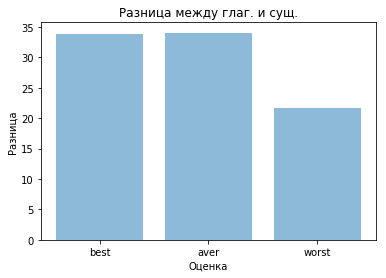

In [37]:
objects = ('best', 'aver', 'worst')
y_pos = np.arange(len(objects))
performance = [float(res[0][0]), float(res[1][0]), float(res[2][0])]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Разница')
plt.xlabel('Оценка')
plt.title('Разница между глаг. и сущ.')
 
plt.show()

Гипотеза не подтвердилась, но, возможно, эксперимент неправильно проведен. Конечно, нужно количество того и того усреднить по общему количеству слов в эссе!

In [38]:
def noun_vs_verbs3(ins_cursor):
    '''
    Возвращает: Срядняя разница между количеством глаголов и существительных в одной группе, ксредненная по количеству токенов
    '''
    sql = "SELECT AVG(table0.avg_diff), m FROM (SELECT TEXTS.name, TEXTS.mark as m, (SUM(DICT_POS.pos = 'NOUN')-SUM(DICT_POS.pos = 'VERB'))/CRITERIA.value as avg_diff FROM TEXTS \
    JOIN TOKENS ON TEXTS.id_text = TOKENS.id_text \
    JOIN CRITERIA ON TEXTS.id_text = CRITERIA.id_text \
    JOIN DICT_POS ON TOKENS.id_pos = DICT_POS.id_pos WHERE DICT_POS.pos = 'NOUN' OR DICT_POS.pos = 'VERB' \
    GROUP BY TEXTS.name, CRITERIA.value, TEXTS.mark) table0 GROUP BY m;"
    ins_cursor.execute(sql)
    result = ins_cursor.fetchall()
    return result

In [39]:
res = noun_vs_verbs3(ins_cursor)

In [40]:
res

[(0.11432144328385144, 'best'),
 (0.13489049175539192, 'aver'),
 (0.13582955841662933, 'worst')]

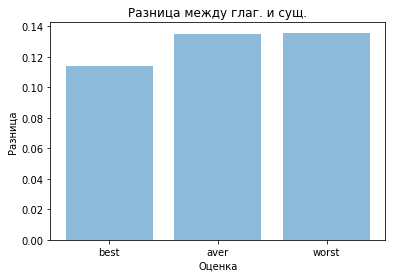

In [41]:
objects = ('best', 'aver', 'worst')
y_pos = np.arange(len(objects))
performance = [float(res[0][0]), float(res[1][0]), float(res[2][0])]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Разница')
plt.xlabel('Оценка')
plt.title('Разница между глаг. и сущ.')
 
plt.show()

Вот тут-то и оно! Нужно все равно другие метрики... Ну или хотя бы посчитать, насколько такая разница значима.